Importing dependencies

In [2]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.0 MB/s eta 0:00:00a 0:00:01


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import calibration_curve

nltk.download('wordnet')  
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /Users/yben409/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yben409/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
lemmatizer = WordNetLemmatizer()

def remove_stop_words(text):
    clean_text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return clean_text

def tokenize_text(text):
    return nltk.word_tokenize(text)

def lemmatize_sentence(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_sentence = ' '.join(lemmatized_tokens)
    return lemmatized_sentence

Importing the clean dataset

In [1]:
dataset = pd.read_csv('Data/Clean Dataset.csv')
dataset

NameError: name 'pd' is not defined

Removing missing values

In [2]:
plt.figure(figsize=(15,6))
sns.heatmap(dataset.isnull().transpose(),cbar_kws={'label': 'Missing Data'})
#No missing values visible, Good data !

NameError: name 'plt' is not defined

In [7]:
#Missing Values... I see you !

In [8]:
print(dataset[dataset['tweets'].isnull()].index)

Index([ 1747,  2436,  2596,  2629,  2762,  3221,  3406,  3437,  5673, 11273,
       11461, 11473, 11528, 11628, 11649, 11682, 11689, 11780, 11798, 11815,
       11838, 11912, 11922, 13745, 13800, 14013, 14034],
      dtype='int64')


In [9]:
dataset.dropna(inplace=True)

In [10]:
nan_indices = dataset[dataset.isna().any(axis=1)].index
print(nan_indices)

Index([], dtype='int64')


In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [12]:
dataset['compound_sentiment'] = dataset['tweets'].apply(lambda tweet: analyzer.polarity_scores(tweet)['compound'])

In [13]:
dataset

,tweets,is_depression,compound_sentiment
0,real reason youre sad youre attached people di...,1,0.2023
1,biggest problem overthinking everything,1,-0.4019
2,worst sadness sadness youve taught hide,1,-0.8910
3,can not make understand can not make anyone un...,1,0.0000
4,dont think anyone really understands tiring ac...,1,0.6369
...,...,...,...
16031,cardi b want trademark catchphrase okurr think...,0,0.0772
16032,ill bet kellyanne george conway pretty disturb...,0,-0.4404
16033,fan always asking watch old stuff finally answ...,0,0.4215
16034,ray romano hilarious comedian kind soul rare n...,0,0.7430


In [14]:
average = dataset.groupby(['is_depression'], as_index=False)['compound_sentiment'].mean()
mi = dataset.groupby(['is_depression'], as_index=False)['compound_sentiment'].min()
ma = dataset.groupby(['is_depression'], as_index=False)['compound_sentiment'].max()
sd = dataset.groupby(['is_depression'], as_index=False)['compound_sentiment'].std()
print("average: " + str(average))
print("min: " + str(mi))
print("max: " + str(ma))
print("std: " + str(sd))

average:    is_depression  compound_sentiment
0              0            0.142185
1              1           -0.168106
min:    is_depression  compound_sentiment
0              0             -0.9601
1              1             -0.9993
max:    is_depression  compound_sentiment
0              0              0.9879
1              1              0.9992
std:    is_depression  compound_sentiment
0              0            0.454744
1              1            0.595216


In [15]:
#Our compound sentiment data is not well normalized, big standard deviation (Scale : [-1,1]) 
#MinMaxScaler is the go to

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset['scaled_compound_sentiment'] = scaler.fit_transform(dataset[['compound_sentiment']])

In [17]:
dataset = dataset.drop('compound_sentiment', axis=1)
dataset

,tweets,is_depression,scaled_compound_sentiment
0,real reason youre sad youre attached people di...,1,0.601251
1,biggest problem overthinking everything,1,0.298924
2,worst sadness sadness youve taught hide,1,0.054191
3,can not make understand can not make anyone un...,1,0.500025
4,dont think anyone really understands tiring ac...,1,0.818714
...,...,...,...
16031,cardi b want trademark catchphrase okurr think...,0,0.538654
16032,ill bet kellyanne george conway pretty disturb...,0,0.279660
16033,fan always asking watch old stuff finally answ...,0,0.710933
16034,ray romano hilarious comedian kind soul rare n...,0,0.871804


In [57]:
dataset.to_csv('Data/Clean Dataset with scaled compound sentiment.csv', index=False)

In [4]:
dataset = pd.read_csv('Data/Clean Dataset.csv')
dataset.dropna(inplace=True)
dataset

,tweets,is_depression
0,real reason youre sad youre attached people di...,1
1,biggest problem overthinking everything,1
2,worst sadness sadness youve taught hide,1
3,can not make understand can not make anyone un...,1
4,dont think anyone really understands tiring ac...,1
...,...,...
16031,cardi b want trademark catchphrase okurr think...,0
16032,ill bet kellyanne george conway pretty disturb...,0
16033,fan always asking watch old stuff finally answ...,0
16034,ray romano hilarious comedian kind soul rare n...,0


In [5]:
X = dataset['tweets']
y = dataset['is_depression']
X

0        real reason youre sad youre attached people di...
1                  biggest problem overthinking everything
2                  worst sadness sadness youve taught hide
3        can not make understand can not make anyone un...
4        dont think anyone really understands tiring ac...
                               ...                        
16031    cardi b want trademark catchphrase okurr think...
16032    ill bet kellyanne george conway pretty disturb...
16033    fan always asking watch old stuff finally answ...
16034    ray romano hilarious comedian kind soul rare n...
16035    muellers report may finished mine next week jo...
Name: tweets, Length: 16009, dtype: object

Test Train Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), test_size=0.05, random_state=4)
len(X_train),len(X_test)

(15208, 801)

Term Frequency Inverse Document Frequency ( TF-IDF Vectorizer )

In [21]:
max_features_values = [50000, 100000]

tfidf_vectorizer = TfidfVectorizer()
 
param_grid = {
    'max_features': max_features_values,
}

grid_search = GridSearchCV(tfidf_vectorizer, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_max_features = grid_search.best_params_['max_features']

print(f"Best max_features: {best_max_features}")

best_tfidf_vectorizer = grid_search.best_estimator_

/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/yben409/opt/anaconda3/lib/python3

Best max_features: 50000


In [7]:
pickle.dump(best_tfidf_vectorizer, open('grid_search_50000_tfidf.pkl', 'wb'))

NameError: name 'best_tfidf_vectorizer' is not defined

In [8]:
best_tfidf_vectorizer = pickle.load(open('grid_search_50000_tfidf.pkl', 'rb'))

In [9]:
X_train_tweets_tfidf = best_tfidf_vectorizer.transform(X_train)
X_test_tweets_tfidf = best_tfidf_vectorizer.transform(X_test)

num_train_samples, _ = X_train_tweets_tfidf.shape
num_test_samples, _ = X_test_tweets_tfidf.shape

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")

Number of training samples: 15208
Number of test samples: 801


In [10]:
# Convert your sparse TF-IDF matrices to dense numpy arrays
X_train_tweets_dense = X_train_tweets_tfidf.toarray()
X_test_tweets_dense = X_test_tweets_tfidf.toarray()

Modeling Section

In [1]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting='soft')

VotingClassifiers.fit(X_train_tweets_dense, y_train)

NameError: name 'GaussianNB' is not defined

In [11]:
pickle.dump(VotingClassifiers, open('Voting_classifier.pkl', 'wb'))

NameError: name 'VotingClassifiers' is not defined

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_tweets_dense, y_train)

/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
pickle.dump(rf_classifier, open('rf_classifier.pkl', 'wb'))

In [53]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_classifier.fit(X_train_tweets_dense, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [68]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier()
clf.fit(X_train_tweets_dense, y_train)

/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier()

Score

In [15]:
rf_classifier = pickle.load(open('rf_classifier.pkl', 'rb'))
VotingClassifiers = pickle.load(open('Voting_classifier.pkl', 'rb'))

In [16]:
print('Training score:', VotingClassifiers.score(X_train_tweets_dense, y_train))
print('Testing score:', VotingClassifiers.score(X_test_tweets_dense, y_test))

Training score: 0.9478563913729616
Testing score: 0.8339575530586767


In [18]:
print('Training score:', rf_classifier.score(X_train_tweets_dense, y_train))
print('Testing score:', rf_classifier.score(X_test_tweets_dense, y_test))

Training score: 0.9996054708048395
Testing score: 0.8826466916354557


In [ ]:
print('Training score:', xgb_classifier.score(X_train_tweets_dense, y_train))
print('Testing score:', xgb_classifier.score(X_test_tweets_dense, y_test))

Training score: 0.9075486586007364
Testing score: 0.8564294631710362


In [14]:
print('Training score:', clf.score(X_train_tweets_dense, y_train))
print('Testing score:', clf.score(X_test_tweets_dense, y_test))

NameError: name 'clf' is not defined

In [ ]:
#Best one is Random Forest Classifier

Preprocessing Function for sentences

In [24]:
def preprocess(element):
    element = element.lower() #convert to lower case 
    element = element.replace(r'[^\w\s]+', '') #remove punctuations
    element = [word for word in element.split() if word not in (stop_words)] #tokenize the sentence
    element = ' '.join([lemmatizer.lemmatize(i) for i in element]) #lemmatizing
    inputToModel = best_tfidf_vectorizer.transform([element]).toarray() #transform to vector form
    return inputToModel

Function to predict preprocessed sentences

In [25]:
def predict_voting(input_text):
    print('Input : ',input_text) 
    processed_array = preprocess(input_text) 
    predict = rf_classifier.predict(processed_array) #Model prediction
    if predict[0] == 1:
        print('Output : Depressed')
    else:
        print('Output : Not depressed')

In [36]:
predict_voting("I woke up today all dizzy, no friends as always.")

Input :  I woke up today all dizzy, no friends as always.
Output : Depressed


In [30]:
predict_voting("Let's go for a hike !")

Input :  Let's go for a hike !
Output : Not depressed


In [19]:
y_pred_voting = VotingClassifiers.predict(X_test_tweets_dense)
y_pred_rf = rf_classifier.predict(X_test_tweets_dense)

In [25]:
y_pred_rf[0:10] , y_pred_voting[0:10]

(array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0]), array([1, 0, 0, 1, 1, 1, 1, 1, 1, 0]))

In [28]:
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred_voting:", y_pred_voting.shape)
print("Shape of y_test_rf:", y_pred_rf.shape)

Shape of y_test: (1, 801)
Shape of y_pred_voting: (1, 801)
Shape of y_test_rf: (1, 801)


In [29]:
y_test = pd.DataFrame(np.array(y_test).reshape(1,-1))
y_pred_rf = pd.DataFrame(np.array(y_pred_rf).reshape(1,-1))
y_pred_voting = pd.DataFrame(np.array(y_pred_voting).reshape(1,-1))

In [30]:
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred_rf:", y_pred_rf.shape)
print("Shape of y_pred_voting:", y_pred_voting.shape)

Shape of y_test: (1, 801)
Shape of y_pred_rf: (1, 801)
Shape of y_pred_voting: (1, 801)


/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

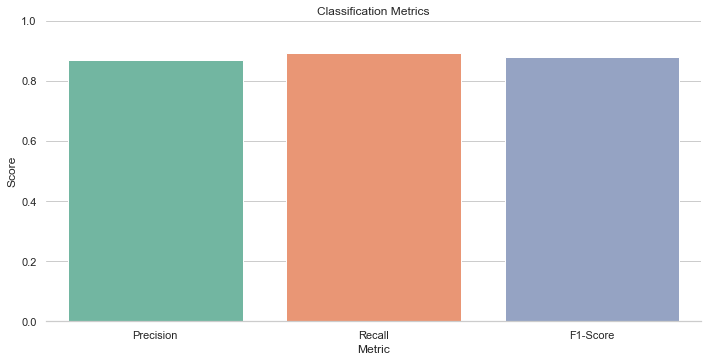

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

precision = precision_score(y_test, y_pred_rf, average='micro')
recall = recall_score(y_test, y_pred_rf, average='micro')
f1 = f1_score(y_test, y_pred_rf, average='micro')

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Score': [precision, recall, f1]
})

sns.set(style="whitegrid")

g = sns.catplot(x='Metric', y='Score', data=metrics_df, kind='bar', palette='Set2', height=5, aspect=2)

g.despine(left=True)
g.set_ylabels('Score')
g.set(ylim=(0, 1.0)) 
plt.title('RF Classification Metrics')

plt.show()

/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

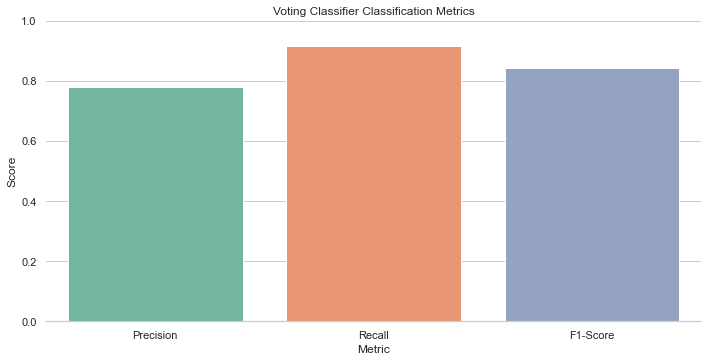

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

precision = precision_score(y_test, y_pred_voting, average='micro')
recall = recall_score(y_test, y_pred_voting, average='micro')
f1 = f1_score(y_test, y_pred_voting, average='micro')

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Score': [precision, recall, f1]
})

sns.set(style="whitegrid")

g = sns.catplot(x='Metric', y='Score', data=metrics_df, kind='bar', palette='Set2', height=5, aspect=2)

g.despine(left=True)
g.set_ylabels('Score')
g.set(ylim=(0, 1.0)) 
plt.title('Voting Classifier Classification Metrics')

plt.show()

In [ ]:
#Random Forest has better metric statistics